In [53]:
#pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import collections
import random
from collections import Counter

import pydicom
import os

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import scipy.ndimage as ndi
from scipy.ndimage import zoom

pd.set_option('display.max_columns', None)

# 2D Image Dataset Extraction
## Preprocessing Steps

## Create Target Variable Dataframe Reference 

### Middle slice number from annotation boxes

In [2]:
annotation_df = pd.read_excel(r"C:\Users\Catherine\Documents\University MSc\Computing Masters\DUKE_Breast_cancer\Image_tables\Annotation_Boxes.xlsx")
annotation_df.head()

,Patient ID,Start Row,End Row,Start Column,End Column,Start Slice,End Slice
0,Breast_MRI_001,234,271,308,341,89,112
1,Breast_MRI_002,251,294,108,136,59,72
2,Breast_MRI_003,351,412,82,139,96,108
3,Breast_MRI_004,262,280,193,204,86,95
4,Breast_MRI_005,188,213,138,178,76,122


In [209]:
def middle_slice_num(start, end):
    middle = np.ceil((start + end) /2)
    return middle

annotation_df["middle slice"] = annotation_df.apply(lambda row: middle_slice_num(row["Start Slice"], row["End Slice"]), axis = 1)

In [210]:
middle_slice = annotation_df[["Patient ID", "middle slice"]]
middle_slice.head()

,Patient ID,middle slice
0,Breast_MRI_001,101.0
1,Breast_MRI_002,66.0
2,Breast_MRI_003,102.0
3,Breast_MRI_004,91.0
4,Breast_MRI_005,99.0


In [211]:
# right so I need to get 101.0 into a string of 1-101
def file_name_edit(mslice):
    slice_num = int(mslice)
    slice_num = str(slice_num).zfill(3)
    new_string= "1-" + slice_num + ".dcm"
    return new_string

middle_slice["string"] = middle_slice.apply(lambda row: file_name_edit(row["middle slice"]), axis = 1)
middle_slice = middle_slice.drop(["middle slice"], axis = 1)
middle_slice.head()    

C:\Users\CATHER~1\AppData\Local\Temp/ipykernel_15648/210293339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_slice["string"] = middle_slice.apply(lambda row: file_name_edit(row["middle slice"]), axis = 1)


,Patient ID,string
0,Breast_MRI_001,1-101.dcm
1,Breast_MRI_002,1-066.dcm
2,Breast_MRI_003,1-102.dcm
3,Breast_MRI_004,1-091.dcm
4,Breast_MRI_005,1-099.dcm


# Target label for Recurrence

In [4]:
dataframe = pd.read_csv(r"C:\Users\Catherine\Documents\University MSc\Computing Masters\DUKE_Breast_cancer\Models\Clinical_and_Other_Features.csv", header = [1])
dataframe2 = dataframe.drop(dataframe.index[0]) 

In [5]:
rec_df =dataframe2[['Patient ID',"Recurrence event(s)",'Date of Birth (Days)', 
                    'Menopause (at diagnosis)', 'Race and Ethnicity','ER', 'PR',
                    'HER2', 'Mol Subtype','Tumor Grade','Unnamed: 32', 'Unnamed: 33',
                    'Staging(Tumor Size)# [T]','Staging(Nodes)#(Nx replaced by -1)[N]'
                   ]]

df= rec_df.rename(columns ={"Tumor Grade" : "Tumor Grade Tubule", 
                            "Unnamed: 32" : "Tumor Grade Nuclear" ,
                            "Unnamed: 33"  : "Tumor Grade Mitotic",
                            'Staging(Tumor Size)# [T]': 'Staging(Tumor Size)',
                            'Staging(Nodes)#(Nx replaced by -1)[N]' : 'Staging(Nodes)'
                           })

df = df.loc[df["Menopause (at diagnosis)"] != 2]
df.head()

,Patient ID,Recurrence event(s),Date of Birth (Days),Menopause (at diagnosis),Race and Ethnicity,ER,PR,HER2,Mol Subtype,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),Staging(Nodes)
1,Breast_MRI_001,0,-15209,0,2,0,0,1,2,3,2,1,2.0,1.0
2,Breast_MRI_002,0,-14061,0,2,0,0,0,3,3,3,3,2.0,0.0
3,Breast_MRI_003,0,-22685,1,1,1,1,0,0,3,2,1,2.0,1.0
4,Breast_MRI_004,0,-21479,1,1,1,1,0,0,3,2,1,1.0,0.0
5,Breast_MRI_005,0,-13932,0,5,1,0,1,1,3,3,3,2.0,1.0


In [6]:
def one_hot_race(dataframe):
    
    race_dict = {"0" : "NaN", 
                 "1" : "White",
                 "2" : "Black",
                 "3" : "Asian",
                 "4" : "Native",
                 "5" : "Hispanic",
                 "6" : "Multi",
                 "7" : "Hawa",
                 "8" : "American Indian"}
    
    df_race = dataframe.replace({"Race and Ethnicity": race_dict})
    df_race = df_race[df_race['Race and Ethnicity'].str.contains('NaN') == False]
    
    col_ohe = pd.get_dummies(df_race["Race and Ethnicity"], prefix="Race and Ethnicity")
    Recurrence_label = pd.concat((df_race, col_ohe), axis=1).drop("Race and Ethnicity", axis=1)
    
    return Recurrence_label

Recurrence_label = one_hot_race(df)

In [7]:
Recurrence_label = Recurrence_label.dropna()
Recurrence_label['Recurrence event(s)'].value_counts()

0    774
1     83
Name: Recurrence event(s), dtype: int64

## Target label for Neoadjuvant treatment

In [308]:
Target_label = dataframe2[['Patient ID','Date of Birth (Days)','Lymphadenopathy or Suspicious Nodes',
                   'PR','Mol Subtype', 'Tumor Grade',
                   'Unnamed: 32', 'Unnamed: 33','Staging(Tumor Size)# [T]',
                   'Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy ',
                   'Staging(Nodes)#(Nx replaced by -1)[N]', 
                   'Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy',
                  ]]


        
Target_label= Target_label.rename(columns ={"Tumor Grade" : "Tumor Grade Tubule", 
                            "Unnamed: 32" : "Tumor Grade Nuclear" ,
                            "Unnamed: 33"  : "Tumor Grade Mitotic",
                            'Staging(Tumor Size)# [T]': 'Staging(Tumor Size)',
                            'Staging(Nodes)#(Nx replaced by -1)[N]' : 'Staging(Nodes)', 
                            })
Target_label.head()

,Patient ID,Date of Birth (Days),Lymphadenopathy or Suspicious Nodes,PR,Mol Subtype,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Staging(Nodes),Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy
1,Breast_MRI_001,-15209,0,0,2,3,2,1,2.0,1,1.0,-1
2,Breast_MRI_002,-14061,0,0,3,3,3,3,2.0,NaN,0.0,NaN
3,Breast_MRI_003,-22685,1,1,0,3,2,1,2.0,1,1.0,1
4,Breast_MRI_004,-21479,0,1,0,3,2,1,1.0,NaN,0.0,NaN
5,Breast_MRI_005,-13932,1,0,1,3,3,3,2.0,0,1.0,0


In [309]:
Target_label = Target_label.dropna()
Target_label = Target_label.loc[Target_label["Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy"] != "-1"]
Target_label = Target_label.loc[Target_label["Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy "] != "-1"]

**create new column based on condition of other columns**

In [310]:
Target_label['Change in (T)'] = Target_label.apply(lambda x: 
                                    int(x["Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy "]) 
                                    - int(x['Staging(Tumor Size)']), axis=1)

Target_label['Change in (N)'] = Target_label.apply(lambda x: 
                                    int(x["Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy"]) 
                                    - int(x['Staging(Nodes)']), axis=1)
    

In [311]:
def response(tumor, node):
    if tumor < 0 or node < 0:
        return 1
    else:
        return 0


Target_label['Response to treatment'] = Target_label.apply(lambda row: 
                                                 response(row['Change in (T)'], row['Change in (N)']), axis=1)
                                                 
Target_label.head()  

,Patient ID,Date of Birth (Days),Lymphadenopathy or Suspicious Nodes,PR,Mol Subtype,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Staging(Nodes),Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy,Change in (T),Change in (N),Response to treatment
3,Breast_MRI_003,-22685,1,1,0,3,2,1,2.0,1,1.0,1,-1,0,1
5,Breast_MRI_005,-13932,1,0,1,3,3,3,2.0,0,1.0,0,-2,-1,1
10,Breast_MRI_010,-24712,1,0,3,3,3,2,3.0,2,2.0,2,-1,0,1
12,Breast_MRI_012,-15885,1,0,3,3,3,3,2.0,2,2.0,2,0,0,0
19,Breast_MRI_019,-13100,0,1,0,3,2,1,1.0,1,1.0,1,0,0,0


In [312]:
Target_label["Response to treatment"].value_counts()

0    95
1    92
Name: Response to treatment, dtype: int64

# Corresponding clinical data to save

In [302]:
def number_formatting(dataframe):
    
    dataframe['Date of Birth (Days)'] = dataframe['Date of Birth (Days)'].map(lambda x: x.lstrip('-'))
    dataframe['Patient ID'] = dataframe['Patient ID'].map(lambda x: x.lstrip('Breast_MRI_'))

    num_data = dataframe.apply(pd.to_numeric)
    
    return num_data

In [303]:
def one_hot_molsubtype(dataframe):

    mol_dict ={"0" : "Luminal A", 
                 "1" : "Luminal B",
                 "2" : "HER2",
                 "3" : "Triple Negative"}

    df_mol = dataframe.replace({"Mol Subtype": mol_dict})

    col_ohe = pd.get_dummies(df_mol["Mol Subtype"], prefix="Mol Subtype")
    mol_data = pd.concat((df_mol, col_ohe), axis=1).drop("Mol Subtype", axis=1)
    
    
    num_data = number_formatting(mol_data)
    
    return num_data

num_data = one_hot_molsubtype(Recurrence_label)
num_data.head()

,Patient ID,Recurrence event(s),Date of Birth (Days),Menopause (at diagnosis),ER,PR,HER2,Tumor Grade Tubule,Tumor Grade Nuclear,Tumor Grade Mitotic,Staging(Tumor Size),Staging(Nodes),Race and Ethnicity_American Indian,Race and Ethnicity_Asian,Race and Ethnicity_Black,Race and Ethnicity_Hawa,Race and Ethnicity_Hispanic,Race and Ethnicity_Multi,Race and Ethnicity_Native,Race and Ethnicity_White,Mol Subtype_HER2,Mol Subtype_Luminal A,Mol Subtype_Luminal B,Mol Subtype_Triple Negative
1,1,0,15209,0,0,0,1,3,2,1,2.0,1.0,0,0,1,0,0,0,0,0,1,0,0,0
2,2,0,14061,0,0,0,0,3,3,3,2.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1
3,3,0,22685,1,1,1,0,3,2,1,2.0,1.0,0,0,0,0,0,0,0,1,0,1,0,0
4,4,0,21479,1,1,1,0,3,2,1,1.0,0.0,0,0,0,0,0,0,0,1,0,1,0,0
5,5,0,13932,0,1,0,1,3,3,3,2.0,1.0,0,0,0,0,1,0,0,0,0,0,1,0


In [ ]:
Neoadjuvant_feature_selected_data = num_data[['Patient ID','Staging(Tumor Size)','Date of Birth (Days)', 'Staging(Nodes)' , 'Tumor Grade Mitotic',
                                  'Mol Subtype_Luminal A', 'Lymphadenopathy or Suspicious Nodes','Tumor Grade Tubule',
                                 'PR', 'Tumor Grade Nuclear', 'Response to treatment']]

In [314]:
Recurrence_feature_selected_data = num_data[['Patient ID','Recurrence event(s)',"Date of Birth (Days)", "Menopause (at diagnosis)", 
                         "Staging(Tumor Size)", "Staging(Nodes)", "PR", "HER2", 
                         "Tumor Grade Tubule","Tumor Grade Mitotic","Tumor Grade Nuclear", 'Mol Subtype_Triple Negative',
                         "Race and Ethnicity_Hispanic", "Race and Ethnicity_Asian"]]

Recurrence_feature_selected_data.head()

,Patient ID,Recurrence event(s),Date of Birth (Days),Menopause (at diagnosis),Staging(Tumor Size),Staging(Nodes),PR,HER2,Tumor Grade Tubule,Tumor Grade Mitotic,Tumor Grade Nuclear,Mol Subtype_Triple Negative,Race and Ethnicity_Hispanic,Race and Ethnicity_Asian
1,1,0,15209,0,2.0,1.0,0,1,3,1,2,0,0,0
2,2,0,14061,0,2.0,0.0,0,0,3,3,3,1,0,0
3,3,0,22685,1,2.0,1.0,1,0,3,1,2,0,0,0
4,4,0,21479,1,1.0,0.0,1,0,3,1,2,0,0,0
5,5,0,13932,0,2.0,1.0,0,1,3,3,3,0,1,0


In [18]:
Neoadjuvant_feature_selected_data.to_csv('Neoadjuvant_clean_clinical.csv')

In [320]:
Recurrence_feature_selected_data.to_csv('Recurrence_clean_clinical.csv')

# Target variable for image extraction

In [11]:
def target_label(df, target_variable, two_D = True):
    
    if two_D == True:
        join_df = pd.merge(df, middle_slice, on = ["Patient ID"])
        dataframe = join_df.loc[:,[ "Patient ID", target_variable, 'string']]
    else:
        dataframe = df.loc[:,["Patient ID", target_variable]]
    
    dataframe = dataframe.set_index('Patient ID')
    
    Patient_Id_list =dataframe.index.values.tolist() 
    
    #print(Patient_Id_list)
    return dataframe, Patient_Id_list
    
    
#target_dataframe, Patient_Id_list = target_label(Target_label, 'Response to treatment')
target_dataframe, Patient_Id_list = target_label(Recurrence_label,'Recurrence event(s)', two_D = False)

target_dataframe.head()

,Recurrence event(s)
Patient ID,
Breast_MRI_001,0
Breast_MRI_002,0
Breast_MRI_003,0
Breast_MRI_004,0
Breast_MRI_005,0


In [12]:
target_dataframe['Recurrence event(s)'].value_counts()

0    774
1     83
Name: Recurrence event(s), dtype: int64

## Convert DICOM File to 2D Numpy Array

for each patient name this function makes an array based on the mri slice thicknes and pixel size and fits the raw data into an array which can be displayed as an image

In [316]:
def pixel_spacing(FilesDCM):

    # Get ref file
    RefDs = pydicom.read_file(FilesDCM)

    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))

    # Load spacing values (in mm)
    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
    
    x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
    
    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    
    return ArrayDicom

In [317]:
def loop_through_slices(lstFilesDCM, ArrayDicom):
    
    ds = pydicom.read_file(lstFilesDCM)
    # store the raw image data
    ArrayDicom[:, :,] = ds.pixel_array  
        
    return ArrayDicom

In [318]:
def resize_data(array, IMG_SIZE):
    
    
    print("original array shape:", array.shape)

    # to find zoom target_size / original_size
    X_zoom = IMG_SIZE / array.shape[0]
    y_zoom = IMG_SIZE / array.shape[1]
    
    new_array = zoom(array, (X_zoom, y_zoom))
    
    return new_array
    

In [319]:
def extract_numpy_array(main_path, patient_id, dataframe, IMG_SIZE, target_label):
    
    PathDicom = os.path.join(main_path, patient_id)
    slice_num = dataframe._get_value(patient_id, "string")
    FullPathDicom = os.path.join(PathDicom, slice_num)

    label = dataframe._get_value(patient_id, target_label)
        
    #build array of 0s based on pixel spacing
    ArrayDicom = pixel_spacing(FullPathDicom)
    
    #input dicom to array 
    full_array =loop_through_slices(FullPathDicom, ArrayDicom)
    
    #resize image
    try:
        resized_array = resize_data(full_array, IMG_SIZE)
        return resized_array, label
    except:
        print("failed resize")
        return full_array, label

In [321]:
mainPath = r"D:\Catherine\Test_run"
IMG_SIZE = 256

def data_extraction(target_variable, IMG_SIZE, dataframe):

    Full_dataset = []

    for patient in Patient_Id_list:
        print(patient)
        try:
            img_label_data = extract_numpy_array(mainPath, patient, dataframe, IMG_SIZE, target_variable)
            #print(img_label_data[0].shape, "Response: ", img_label_data[1])

            Full_dataset.append([img_label_data[0], int(img_label_data[1]), patient])

        except:
            print(patient, " file not found")
    
    return Full_dataset

#Full_dataset = data_extraction('Response to treatment', IMG_SIZE , target_dataframe)  
Full_dataset = data_extraction('Recurrence event(s)', IMG_SIZE, target_dataframe)            

Breast_MRI_001
original array shape: (448, 448)
Breast_MRI_002
original array shape: (512, 512)
Breast_MRI_003
original array shape: (512, 512)
Breast_MRI_004
original array shape: (512, 512)
Breast_MRI_005
original array shape: (448, 448)
Breast_MRI_006
original array shape: (512, 512)
Breast_MRI_007
original array shape: (448, 448)
Breast_MRI_008
original array shape: (448, 448)
Breast_MRI_009
original array shape: (512, 512)
Breast_MRI_010
original array shape: (512, 512)
Breast_MRI_011
original array shape: (512, 512)
Breast_MRI_012
original array shape: (512, 512)
Breast_MRI_013
original array shape: (512, 512)
Breast_MRI_014
original array shape: (448, 448)
Breast_MRI_015
original array shape: (448, 448)
Breast_MRI_017
original array shape: (448, 448)
Breast_MRI_018
original array shape: (448, 448)
Breast_MRI_019
original array shape: (320, 320)
Breast_MRI_020
original array shape: (512, 512)
Breast_MRI_021
original array shape: (512, 512)
Breast_MRI_022
original array shape: (44

original array shape: (448, 448)
Breast_MRI_190
original array shape: (512, 512)
Breast_MRI_191
original array shape: (512, 512)
Breast_MRI_192
original array shape: (448, 448)
Breast_MRI_193
original array shape: (512, 512)
Breast_MRI_194
original array shape: (512, 512)
Breast_MRI_195
original array shape: (448, 448)
Breast_MRI_196
original array shape: (448, 448)
Breast_MRI_197
original array shape: (448, 448)
Breast_MRI_198
original array shape: (448, 448)
Breast_MRI_199
original array shape: (512, 512)
Breast_MRI_200
original array shape: (320, 320)
Breast_MRI_201
original array shape: (448, 448)
Breast_MRI_202
original array shape: (448, 448)
Breast_MRI_204
original array shape: (448, 448)
Breast_MRI_205
original array shape: (512, 512)
Breast_MRI_206
original array shape: (512, 512)
Breast_MRI_207
original array shape: (512, 512)
Breast_MRI_208
original array shape: (512, 512)
Breast_MRI_209
original array shape: (448, 448)
Breast_MRI_210
original array shape: (448, 448)
Breast_

original array shape: (320, 320)
Breast_MRI_372
original array shape: (512, 512)
Breast_MRI_374
original array shape: (512, 512)
Breast_MRI_375
original array shape: (448, 448)
Breast_MRI_376
original array shape: (448, 448)
Breast_MRI_377
original array shape: (512, 512)
Breast_MRI_378
original array shape: (512, 512)
Breast_MRI_379
original array shape: (448, 448)
Breast_MRI_380
original array shape: (512, 512)
Breast_MRI_381
original array shape: (512, 512)
Breast_MRI_382
original array shape: (512, 512)
Breast_MRI_383
original array shape: (512, 512)
Breast_MRI_384
original array shape: (448, 448)
Breast_MRI_385
original array shape: (448, 448)
Breast_MRI_387
original array shape: (512, 512)
Breast_MRI_388
original array shape: (512, 512)
Breast_MRI_389
original array shape: (512, 512)
Breast_MRI_390
original array shape: (512, 512)
Breast_MRI_391
original array shape: (512, 512)
Breast_MRI_392
original array shape: (512, 512)
Breast_MRI_393
original array shape: (512, 512)
Breast_

original array shape: (448, 448)
Breast_MRI_555
original array shape: (512, 512)
Breast_MRI_556
original array shape: (512, 512)
Breast_MRI_557
original array shape: (512, 512)
Breast_MRI_558
original array shape: (512, 512)
Breast_MRI_559
original array shape: (448, 448)
Breast_MRI_560
original array shape: (512, 512)
Breast_MRI_561
original array shape: (512, 512)
Breast_MRI_562
original array shape: (448, 448)
Breast_MRI_563
original array shape: (512, 512)
Breast_MRI_564
original array shape: (448, 448)
Breast_MRI_565
original array shape: (512, 512)
Breast_MRI_566
original array shape: (512, 512)
Breast_MRI_567
original array shape: (512, 512)
Breast_MRI_568
original array shape: (448, 448)
Breast_MRI_569
original array shape: (448, 448)
Breast_MRI_570
original array shape: (448, 448)
Breast_MRI_571
original array shape: (512, 512)
Breast_MRI_572
original array shape: (512, 512)
Breast_MRI_573
original array shape: (512, 512)
Breast_MRI_575
original array shape: (512, 512)
Breast_

original array shape: (512, 512)
Breast_MRI_740
original array shape: (512, 512)
Breast_MRI_741
original array shape: (448, 448)
Breast_MRI_742
original array shape: (512, 512)
Breast_MRI_744
original array shape: (512, 512)
Breast_MRI_745
original array shape: (512, 512)
Breast_MRI_746
original array shape: (512, 512)
Breast_MRI_747
original array shape: (512, 512)
Breast_MRI_748
original array shape: (512, 512)
Breast_MRI_749
original array shape: (448, 448)
Breast_MRI_750
original array shape: (512, 512)
Breast_MRI_751
original array shape: (512, 512)
Breast_MRI_752
original array shape: (512, 512)
Breast_MRI_753
original array shape: (512, 512)
Breast_MRI_754
original array shape: (448, 448)
Breast_MRI_755
original array shape: (512, 512)
Breast_MRI_756
original array shape: (320, 320)
Breast_MRI_757
original array shape: (512, 512)
Breast_MRI_758
original array shape: (512, 512)
Breast_MRI_759
original array shape: (448, 448)
Breast_MRI_760
original array shape: (512, 512)
Breast_

# Visulise some of the slices and their labels

In [336]:
class_0 = []
class_1 = []

for patient in Full_dataset:
    if patient[1] == 0:
        class_0.append(patient)
    elif patient[1] == 1:
        class_1.append(patient)
    else:
        print("error with ", patient[2])

random.shuffle(class_0)
random.shuffle(class_1)   
print(len(class_0))

765


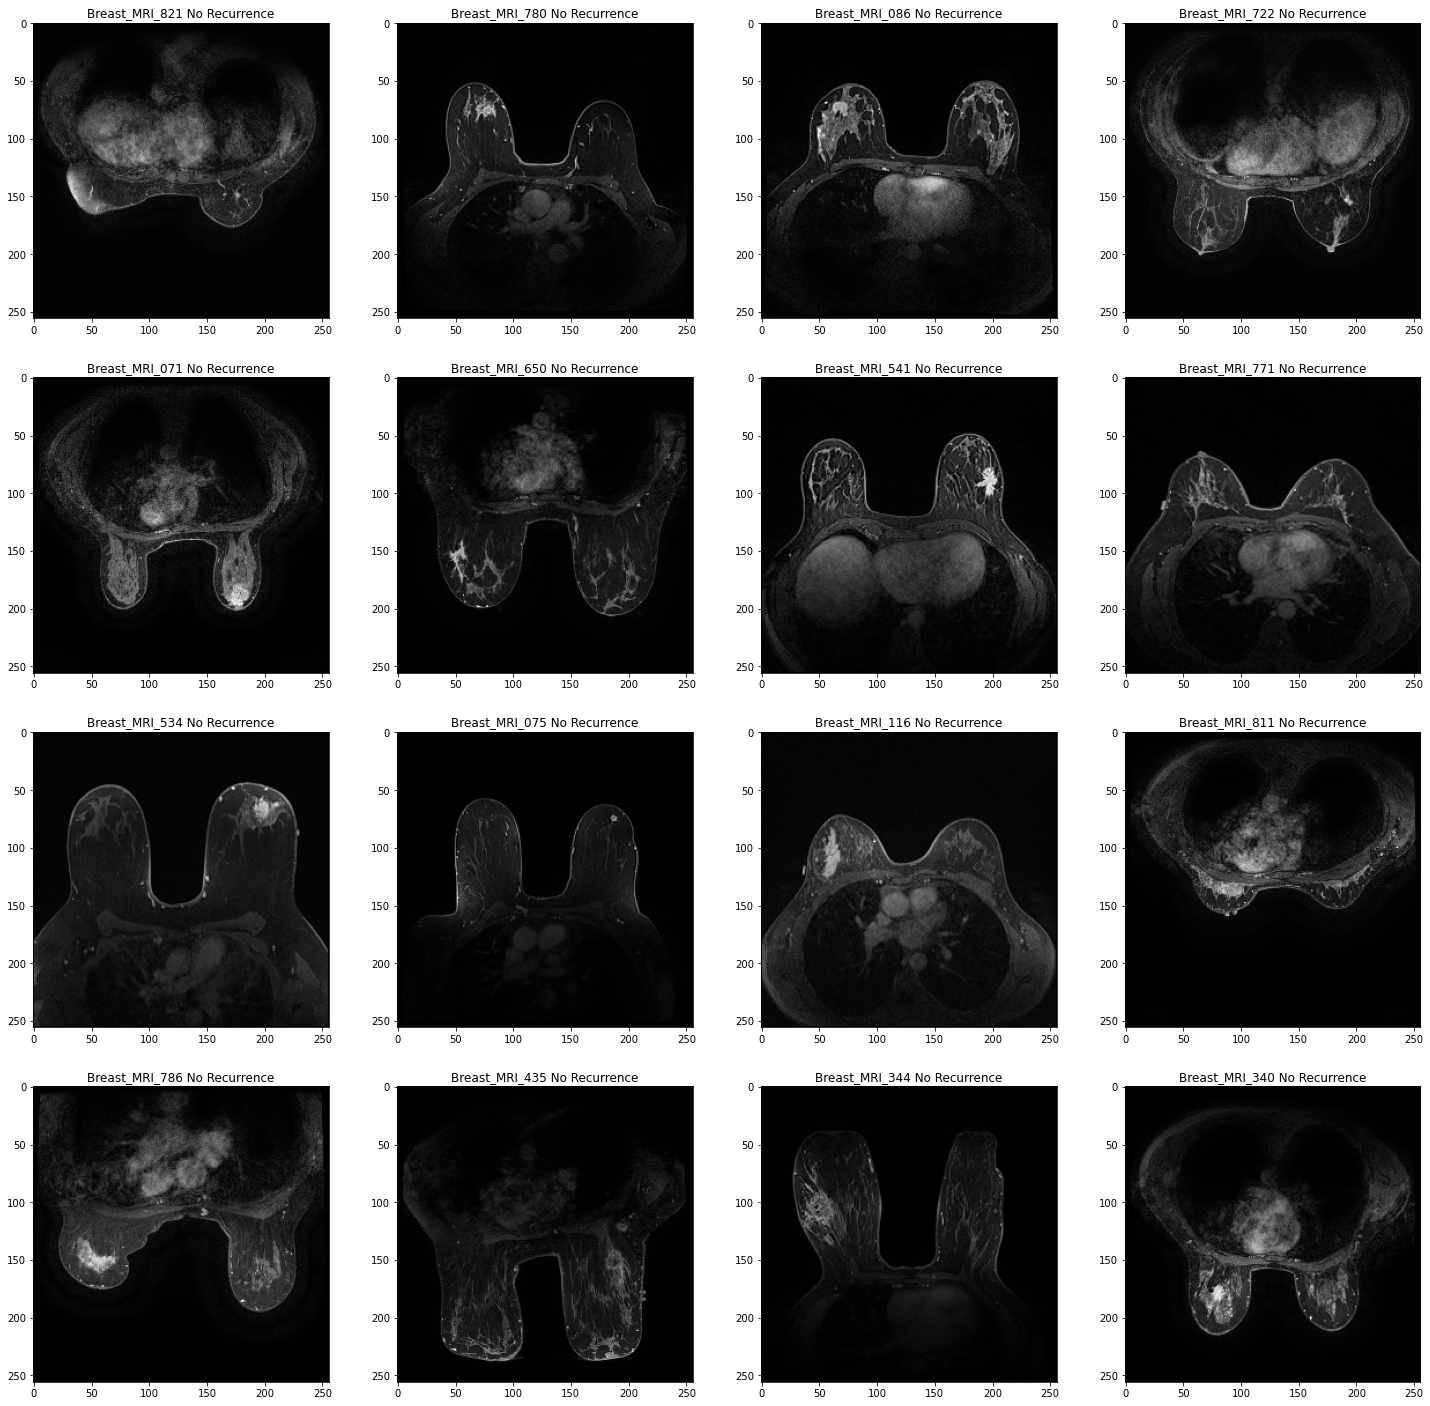

In [338]:
fig, ax = plt.subplots(4, 4, figsize=[25, 25])
ax = ax.flatten()

for i, patient in enumerate(class_0[:16]): 
    ax[i].imshow(patient[0], cmap='gray')
    ax[i].title.set_text(str(patient[2]) +" No Recurrence")

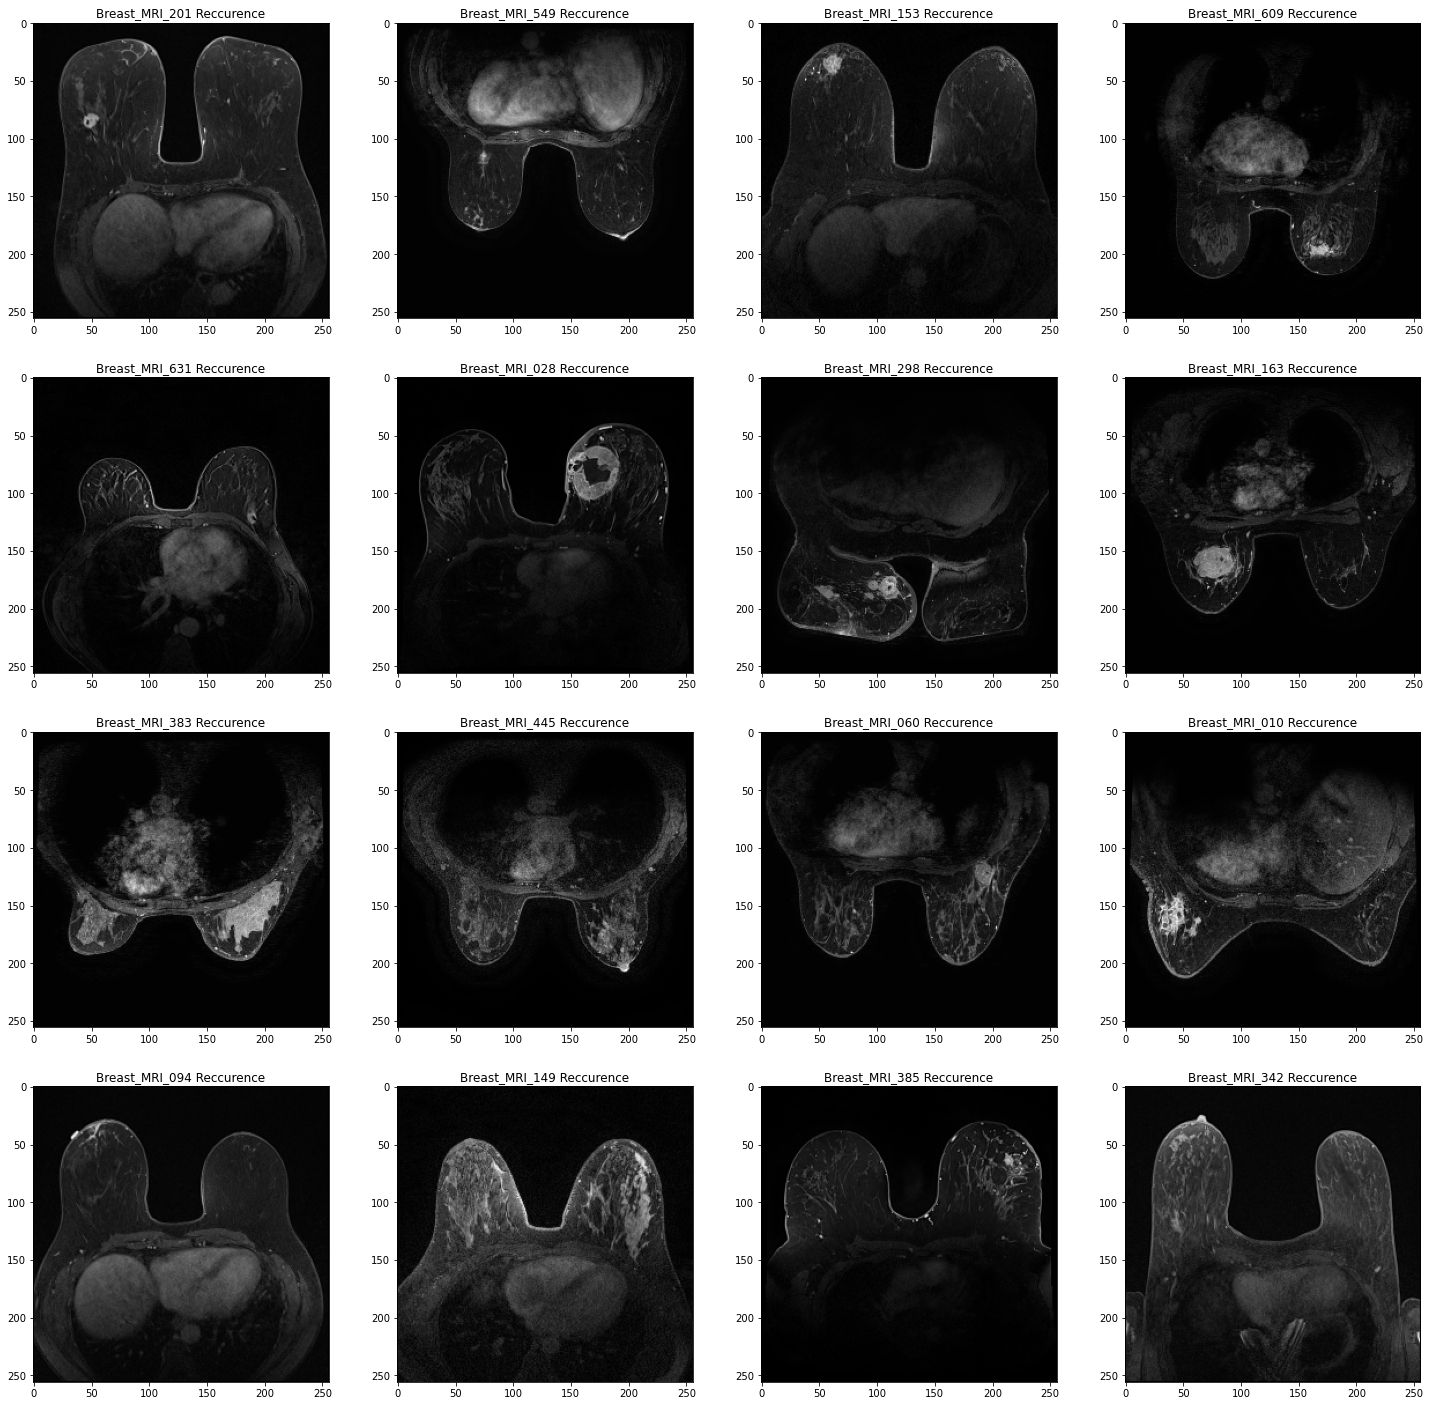

In [339]:
fig, ax = plt.subplots(4, 4, figsize=[25, 25])
ax = ax.flatten()

for i, patient in enumerate(class_1[:16]): 
    ax[i].imshow(patient[0], cmap='gray')
    ax[i].title.set_text(str(patient[2]) +" Reccurence")

In [323]:
#to save the list of arrays
np.save("Breast_dataset-2D-{}-{}.npy".format(IMG_SIZE, "Recurrence with identifier"), Full_dataset)

C:\Users\Catherine\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [326]:
dataset = np.load('Breast_dataset-2D-256-Recurrence with identifier.npy', allow_pickle=True)

In [327]:
print(len(dataset))

848


# 3D Image Extraction

In [13]:
def pixel_spacing(lstFilesDCM):

    # Get ref file
    RefDs = pydicom.read_file(lstFilesDCM[0])

    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

    # Load spacing values (in mm)
    ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))
    
    x = np.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
    y = np.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
    z = np.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])
    
    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    
    return ArrayDicom

In [14]:
def loop_through_slices(lstFilesDCM, ArrayDicom):
    
    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = pydicom.read_file(filenameDCM)
        # store the raw image data
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  
        
    return ArrayDicom

In [15]:
def resize_data(array, IMG_SIZE, SLICE_NUM):
    
            
    # so I want an array of (256x256x80) but we don't know start dimensions
    #note I'm pretty sure all x and y are the same dimensions (square) 
    
    print("original array shape:", array.shape)

    # to find zoom target_size / original_size
    X_zoom = IMG_SIZE / array.shape[0]
    y_zoom = IMG_SIZE / array.shape[1]
    

    if array.shape[2] % 2 == 0:
        z_zoom = SLICE_NUM / array.shape[2]
    else:
        print("odd number")
        np.delete(array, 0, axis = 2)
        print(array.shape)
        z_zoom = SLICE_NUM / array.shape[2]

    new_array = zoom(array, (X_zoom, y_zoom, z_zoom))
    
    return new_array
    

In [16]:
def extract_numpy_array(main_path, patient_id, dataframe, IMG_SIZE, SLICE_NUM, target_label):
    
    PathDicom = os.path.join(main_path, patient_id)
    label = dataframe._get_value(patient, target_label)
    print(patient_id)
    lstFilesDCM = []  # create an empty list
    
    for dirName, subdirList, fileList in os.walk(PathDicom):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))
                
    ArrayDicom = pixel_spacing(lstFilesDCM)
    large_array =loop_through_slices(lstFilesDCM, ArrayDicom)
    try:
        resized_array = resize_data(large_array, IMG_SIZE, SLICE_NUM)
        return resized_array, label
    except:
        print("failed resize")
        return large_array, label

In [19]:
mainPath = r"D:\Catherine\Test_run"

Full_dataset = []
IMG_SIZE = 128
SLICE_NUM = 60

def data_extraction(target_variable, IMG_SIZE, SLICE_NUM, dataframe):

    Full_dataset = []

    for patient in Patient_Id_list:
        print(patient)
        try:
            img_label_data = extract_numpy_array(mainPath, patient, dataframe, IMG_SIZE, SLICE_NUM ,target_variable)
            #print(img_label_data[0].shape, "Response: ", img_label_data[1])

            Full_dataset.append([img_label_data[0], int(img_label_data[1]), patient])

        except:
            print(patient, " file not found")
    
    return Full_dataset

Full_dataset = data_extraction('Recurrence event(s)', IMG_SIZE, SLICE_NUM, target_dataframe)  

Breast_MRI_001
Breast_MRI_001
original array shape: (448, 448, 160)
Breast_MRI_002
Breast_MRI_002
original array shape: (512, 512, 142)
Breast_MRI_003
Breast_MRI_003
original array shape: (512, 512, 156)
Breast_MRI_004
Breast_MRI_004
original array shape: (512, 512, 164)
Breast_MRI_005
Breast_MRI_005
original array shape: (448, 448, 160)
Breast_MRI_006
Breast_MRI_006
original array shape: (512, 512, 148)
Breast_MRI_007
Breast_MRI_007
original array shape: (448, 448, 208)
Breast_MRI_008
Breast_MRI_008
original array shape: (448, 448, 160)
Breast_MRI_009
Breast_MRI_009
original array shape: (512, 512, 156)
Breast_MRI_010
Breast_MRI_010
original array shape: (512, 512, 146)
Breast_MRI_011
Breast_MRI_011
original array shape: (512, 512, 184)
Breast_MRI_012
Breast_MRI_012
original array shape: (512, 512, 178)
Breast_MRI_013
Breast_MRI_013
original array shape: (512, 512, 174)
Breast_MRI_014
Breast_MRI_014
original array shape: (448, 448, 176)
Breast_MRI_015
Breast_MRI_015
original array sha

Breast_MRI_134
Breast_MRI_134
original array shape: (512, 512, 142)
Breast_MRI_135
Breast_MRI_135
original array shape: (512, 512, 176)
Breast_MRI_136
Breast_MRI_136
original array shape: (512, 512, 170)
Breast_MRI_137
Breast_MRI_137
original array shape: (448, 448, 128)
Breast_MRI_138
Breast_MRI_138
original array shape: (512, 512, 192)
Breast_MRI_139
Breast_MRI_139
original array shape: (448, 448, 160)
Breast_MRI_141
Breast_MRI_141
original array shape: (448, 448, 208)
Breast_MRI_142
Breast_MRI_142
original array shape: (448, 448, 176)
Breast_MRI_143
Breast_MRI_143
original array shape: (448, 448, 128)
Breast_MRI_144
Breast_MRI_144
original array shape: (448, 448, 144)
Breast_MRI_145
Breast_MRI_145
original array shape: (512, 512, 176)
Breast_MRI_146
Breast_MRI_146
original array shape: (512, 512, 160)
Breast_MRI_147
Breast_MRI_147
original array shape: (512, 512, 176)
Breast_MRI_148
Breast_MRI_148
original array shape: (512, 512, 142)
Breast_MRI_149
Breast_MRI_149
original array sha

Breast_MRI_264
Breast_MRI_264
original array shape: (512, 512, 176)
Breast_MRI_265
Breast_MRI_265
original array shape: (448, 448, 160)
Breast_MRI_266
Breast_MRI_266
original array shape: (448, 448, 160)
Breast_MRI_267
Breast_MRI_267
original array shape: (512, 512, 160)
Breast_MRI_268
Breast_MRI_268
original array shape: (448, 448, 160)
Breast_MRI_269
Breast_MRI_269
original array shape: (512, 512, 172)
Breast_MRI_270
Breast_MRI_270
original array shape: (448, 448, 208)
Breast_MRI_271
Breast_MRI_271
original array shape: (320, 320, 160)
Breast_MRI_272
Breast_MRI_272
original array shape: (512, 512, 200)
Breast_MRI_273
Breast_MRI_273
original array shape: (512, 512, 176)
Breast_MRI_274
Breast_MRI_274
original array shape: (512, 512, 176)
Breast_MRI_275
Breast_MRI_275
original array shape: (448, 448, 192)
Breast_MRI_276
Breast_MRI_276
original array shape: (512, 512, 192)
Breast_MRI_277
Breast_MRI_277
original array shape: (512, 512, 196)
Breast_MRI_278
Breast_MRI_278
original array sha

Breast_MRI_392
Breast_MRI_392
original array shape: (512, 512, 168)
Breast_MRI_393
Breast_MRI_393
original array shape: (512, 512, 170)
Breast_MRI_395
Breast_MRI_395
original array shape: (512, 512, 182)
Breast_MRI_396
Breast_MRI_396
original array shape: (512, 512, 126)
Breast_MRI_397
Breast_MRI_397
original array shape: (512, 512, 180)
Breast_MRI_398
Breast_MRI_398
original array shape: (448, 448, 144)
Breast_MRI_399
Breast_MRI_399
original array shape: (512, 512, 152)
Breast_MRI_400
Breast_MRI_400
original array shape: (512, 512, 158)
Breast_MRI_402
Breast_MRI_402
original array shape: (512, 512, 188)
Breast_MRI_403
Breast_MRI_403
original array shape: (512, 512, 188)
Breast_MRI_405
Breast_MRI_405
original array shape: (448, 448, 224)
Breast_MRI_407
Breast_MRI_407
original array shape: (512, 512, 200)
Breast_MRI_408
Breast_MRI_408
original array shape: (512, 512, 186)
Breast_MRI_409
Breast_MRI_409
original array shape: (448, 448, 144)
Breast_MRI_410
Breast_MRI_410
original array sha

Breast_MRI_521
Breast_MRI_521
original array shape: (512, 512, 174)
Breast_MRI_522
Breast_MRI_522
original array shape: (512, 512, 160)
Breast_MRI_523
Breast_MRI_523
Breast_MRI_523  file not found
Breast_MRI_524
Breast_MRI_524
original array shape: (512, 512, 192)
Breast_MRI_525
Breast_MRI_525
original array shape: (512, 512, 196)
Breast_MRI_526
Breast_MRI_526
original array shape: (448, 448, 176)
Breast_MRI_527
Breast_MRI_527
original array shape: (448, 448, 208)
Breast_MRI_528
Breast_MRI_528
original array shape: (512, 512, 172)
Breast_MRI_529
Breast_MRI_529
original array shape: (448, 448, 160)
Breast_MRI_530
Breast_MRI_530
original array shape: (512, 512, 174)
Breast_MRI_531
Breast_MRI_531
Breast_MRI_531  file not found
Breast_MRI_532
Breast_MRI_532
original array shape: (512, 512, 142)
Breast_MRI_533
Breast_MRI_533
original array shape: (448, 448, 128)
Breast_MRI_534
Breast_MRI_534
original array shape: (448, 448, 176)
Breast_MRI_536
Breast_MRI_536
original array shape: (512, 512,

Breast_MRI_651
Breast_MRI_651
original array shape: (320, 320, 160)
Breast_MRI_652
Breast_MRI_652
original array shape: (512, 512, 158)
Breast_MRI_653
Breast_MRI_653
original array shape: (512, 512, 168)
Breast_MRI_654
Breast_MRI_654
original array shape: (512, 512, 166)
Breast_MRI_655
Breast_MRI_655
original array shape: (512, 512, 130)
Breast_MRI_656
Breast_MRI_656
original array shape: (448, 448, 176)
Breast_MRI_657
Breast_MRI_657
original array shape: (512, 512, 164)
Breast_MRI_658
Breast_MRI_658
original array shape: (512, 512, 192)
Breast_MRI_659
Breast_MRI_659
original array shape: (448, 448, 176)
Breast_MRI_660
Breast_MRI_660
original array shape: (512, 512, 196)
Breast_MRI_661
Breast_MRI_661
original array shape: (512, 512, 168)
Breast_MRI_662
Breast_MRI_662
original array shape: (448, 448, 224)
Breast_MRI_663
Breast_MRI_663
original array shape: (512, 512, 160)
Breast_MRI_664
Breast_MRI_664
Breast_MRI_664  file not found
Breast_MRI_665
Breast_MRI_665
original array shape: (51

Breast_MRI_781
Breast_MRI_781
original array shape: (512, 512, 174)
Breast_MRI_782
Breast_MRI_782
original array shape: (448, 448, 208)
Breast_MRI_783
Breast_MRI_783
original array shape: (448, 448, 176)
Breast_MRI_784
Breast_MRI_784
original array shape: (512, 512, 196)
Breast_MRI_785
Breast_MRI_785
original array shape: (512, 512, 192)
Breast_MRI_786
Breast_MRI_786
original array shape: (512, 512, 188)
Breast_MRI_787
Breast_MRI_787
original array shape: (512, 512, 160)
Breast_MRI_788
Breast_MRI_788
original array shape: (448, 448, 208)
Breast_MRI_789
Breast_MRI_789
original array shape: (512, 512, 186)
Breast_MRI_790
Breast_MRI_790
original array shape: (512, 512, 142)
Breast_MRI_791
Breast_MRI_791
original array shape: (448, 448, 192)
Breast_MRI_792
Breast_MRI_792
original array shape: (512, 512, 200)
Breast_MRI_793
Breast_MRI_793
original array shape: (512, 512, 188)
Breast_MRI_794
Breast_MRI_794
original array shape: (512, 512, 176)
Breast_MRI_796
Breast_MRI_796
original array sha

Breast_MRI_912
Breast_MRI_912
original array shape: (512, 512, 176)
Breast_MRI_913
Breast_MRI_913
original array shape: (512, 512, 142)
Breast_MRI_914
Breast_MRI_914
original array shape: (512, 512, 154)
Breast_MRI_915
Breast_MRI_915
original array shape: (512, 512, 160)
Breast_MRI_917
Breast_MRI_917
original array shape: (512, 512, 176)
Breast_MRI_918
Breast_MRI_918
original array shape: (512, 512, 192)
Breast_MRI_919
Breast_MRI_919
original array shape: (512, 512, 192)
Breast_MRI_920
Breast_MRI_920
original array shape: (448, 448, 160)
Breast_MRI_921
Breast_MRI_921
original array shape: (512, 512, 174)
Breast_MRI_922
Breast_MRI_922
original array shape: (512, 512, 174)


In [20]:
np.save("Breast_dataset_recurrence-{}-{}-{}-with identifier.npy".format(IMG_SIZE, IMG_SIZE, SLICE_NUM), Full_dataset)

C:\Users\Catherine\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [22]:
dataset = np.load('Breast_dataset_recurrence-128-128-60-with identifier.npy', allow_pickle=True)

## Patient with no recurrence

In [23]:
print(dataset[2][0].shape)
print(dataset[2][1])
image = dataset[2][0] 

(128, 128, 60)
0


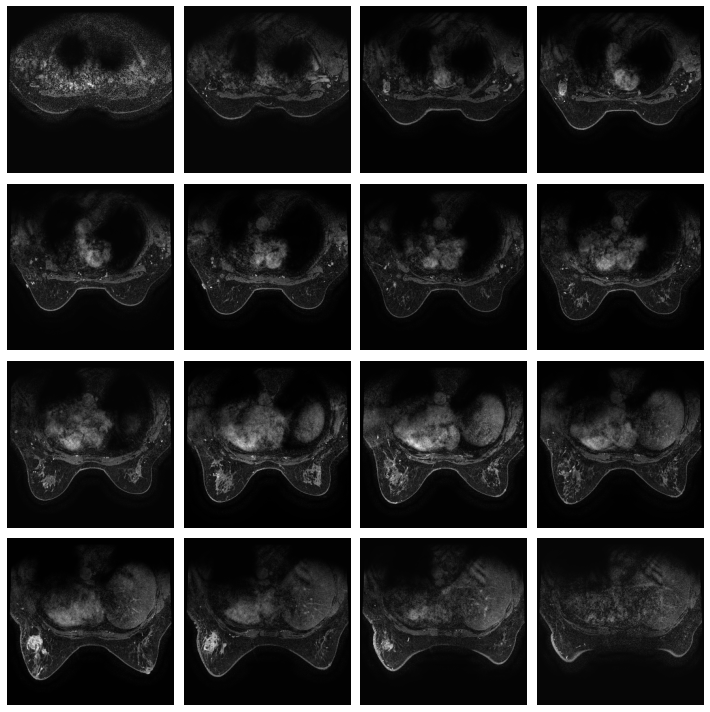

In [14]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = image.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(image[ :, :,img], cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

## Patient with Recurrence

In [90]:
print(Full_dataset[11][0].shape)
image = Full_dataset[11][0] 

(256, 256, 80)


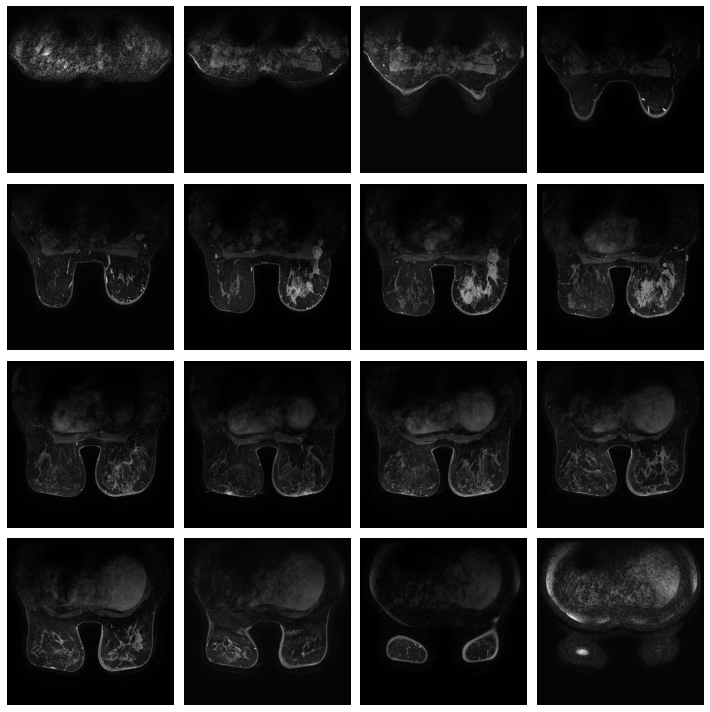

In [91]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = image.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(image[ :, :,img], cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()